#Librerias

In [1]:
# Cálculo numérico y manipulación de datos
import numpy as np
import pandas as pd

# Aprendizaje automático y deep learning
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Procesamiento de imágenes
import cv2

# Manejo de archivos Excel
import openpyxl

# Sistema y gestión de archivos
import os
import sys

# Conectar con google drive

In [2]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [4]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

#Despliegue

In [5]:
#Definición de rutas
path_imagenes="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Data/despliegue"
path_modelo="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/skin_cancer_model.h5"
path_resultados="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/Salida_despliegue"

In [6]:
## Definir umbrales personalizados para clasificación
umbral_inferior = 0.08
umbral_superior = 0.95

In [14]:
#### cargar datos ####
path = path_imagenes # ruta de imagenes a clasificar
x, _, files= fn.load_images(path_imagenes) #cargar datos de despliegue

x = np.array(x).astype('float32') / 255.0 #Escalar datos

### Eliminar extension a nombre de archivo
lista_numeros=[] #Lista de etiquetas actuales sin extension
lista_nombres=[] #Lista para contener los nuevos nombres

#Eliminar extension del nombre
for i in files:
    numero=i.split('.')
    lista_numeros.append(numero[0])

# Cargar modelo entrenado
modelo = tf.keras.models.load_model(path_modelo)

# Realizar predicciones (probabilidades)
probabilidades = modelo.predict(x)

# Clasificar según umbrales definidos para cáncer de piel
clasificaciones = [
    'Cáncer' if prob > umbral_superior else
    'Normal' if prob < umbral_inferior else
    'No_identificado'
    for prob in probabilidades.flatten()
]


# Organizar salida de datos en un dataframe
resultados={
    "Nombre_archivo": files,
    "Clasificación_predicciones": clasificaciones,
    "Probabilidad": probabilidades.flatten()
}
resultados=pd.DataFrame(resultados)


100%|██████████| 400/400 [00:04<00:00, 91.18it/s] 


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step


## Matriz de confusión

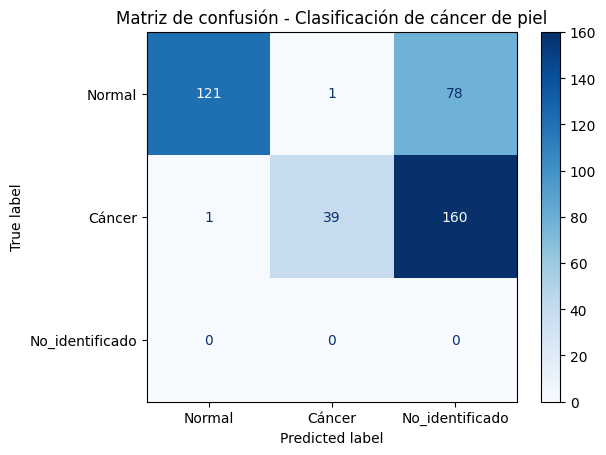

In [15]:
#Crear matriz de confusion con datos de despliegue
y_true = []

for num in lista_numeros:
    if int(num) <= 199:  # Rango de benignos
        y_true.append("Normal")
    else:                # Rango de malignos
        y_true.append("Cáncer")

# Matriz de confusión
cm = confusion_matrix(y_true, clasificaciones, labels=["Normal", "Cáncer", "No_identificado"])

# Visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Cáncer", "No_identificado"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Clasificación de cáncer de piel")
plt.show()

## Salida a Excel

In [17]:
#Exportar resultados en formato xlsx
resultados.to_excel(path_resultados+'/resultados.xlsx', index=False)